牛顿模型
入口压力（MPa）： 3.07942
井底压力（MPa）：61.84232
钻柱摩擦压降（MPa）： 0.08111
环空摩擦压降（MPa）： 2.88232
钻头压降（MPa）： 0.01598


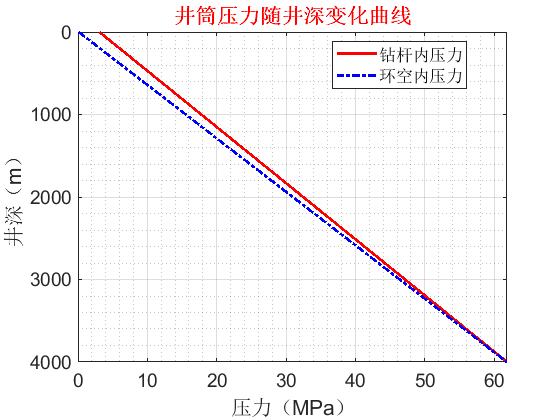

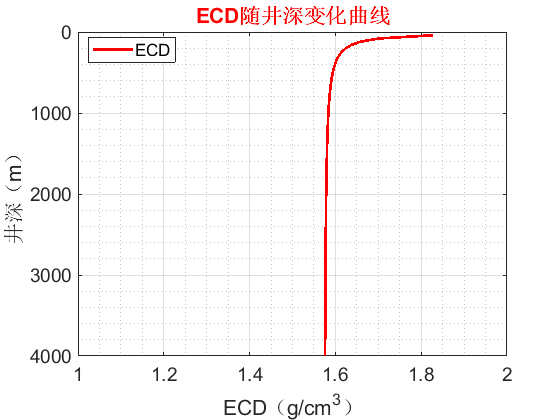

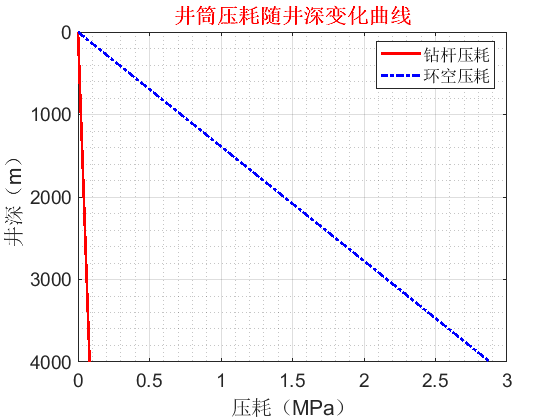

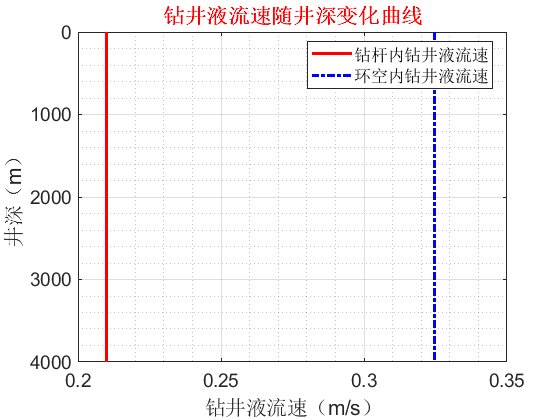

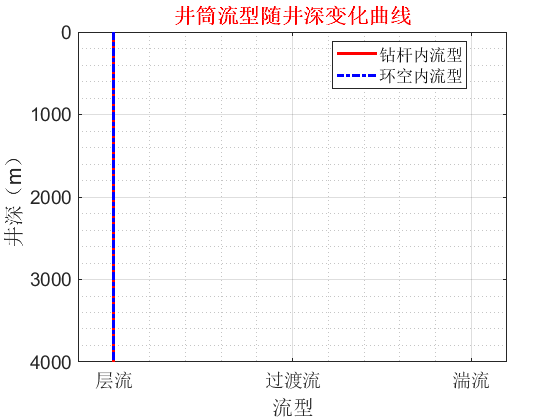

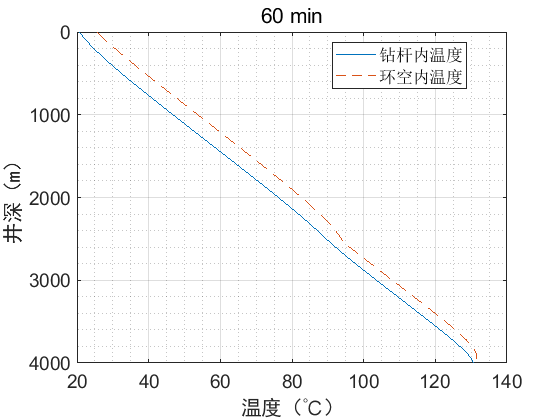

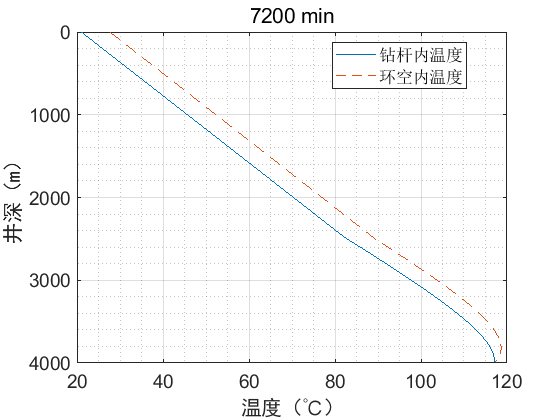

In [2]:
clear all;clc;close all % 清除数据
cd("D:\桌面\毕设\材料\20221127-结题材料\03-源代码\02 - 井筒压力\01-Newtonian\Newtonian-NormalTP\ConstantGeometry")
%% 数据输入及预处理（国际单位制）
T_0=20; % T_0为测试温度（℃）
P_0=101325; % P_0为测试压力（Pa）
data_rheology=csvread('RheologyData.csv',1,0); % data_rheology存储测试温度和压力条件下的牛顿流体六速粘度计数据，第一列为转速，第二列为读数；因存在表头且csv只能读取纯数据，1代表从第2行开始读取，0代表从第1列开始读取
mu_0=Rheology_Newtonian(data_rheology); % 根据测试温度、压力条件下的牛顿流体六速粘度计数据，采用回归法计算得到黏度mu_0（Pa·s）

welldepth=4000; % 井深，m
nx=100; % 空间网格数
Nx=nx+1; % 空间节点数
Depth(1)=0; % 空间节点，m
for i=1:Nx-1
    dz(i)=welldepth/(Nx-1); % 空间步长，m
    Depth(i+1)=Depth(i)+dz(i); % 空间节点，m
end

for i=1:1:Nx
    theta(i)=0; % theta为井斜角（°），以铅垂线为起始线
    theta(i)=theta(i)/180*pi; % 将井斜角单位转换为弧度
    D_w(i)=0.14; % D_w为井筒内径（m）
    D_d_o(i)=0.1143; % D_d_o为钻杆外径（m）
    D_d_i(i)=0.10053; % D_d_i为钻杆内径（m）
    A_d(i)=1/4*pi*D_d_i(i)^2; % A_d为钻杆截面积（m^2）
    A_a(i)=1/4*pi*(D_w(i)^2-D_d_o(i)^2); % A_a为环空截面积（m^2）
end

rho_0=1500; % rho_0为测试温度、压力下的钻井液密度（kg/m^3）
Qv_0=0.1/60; % 钻井液体积流量（m^3/s）
Qm_0=Qv_0*rho_0; % Qm_0为测试温度、压力下的钻井液质量排量（kg/s）
g=9.81; % g为重力加速度（m/s^2）

%% 温度计算
[T_a_T,T_d_T,Depth_T,Time_T]=Temperature(welldepth,rho_0,mu_0,Qv_0); % 计算温度场参数（环空温度（℃），管内温度（℃），空间节点（m），时间节点（s））

%% 插值计算空间节点Depth对应的环空温度T_A和管内温度T_D
[r,c]=size(T_a_T);
for t=1:1:c
    for x=1:1:Nx
        for i=1:1:r-1
            if Depth(x)>=Depth_T(i) && Depth(x)<Depth_T(i+1)
                T_A(x,t)=T_a_T(i,t)+(T_a_T(i+1,t)-T_a_T(i,t))*(Depth(x)-Depth_T(i))/(Depth_T(i+1)-Depth_T(i)); % 环空钻井液温度，℃
                T_D(x,t)=T_d_T(i,t)+(T_d_T(i+1,t)-T_d_T(i,t))*(Depth(x)-Depth_T(i))/(Depth_T(i+1)-Depth_T(i)); % 管内钻井液温度，℃
            elseif Depth(x)==Depth_T(i+1)
                T_A(x,t)=T_a_T(i+1,t); % 环空钻井液温度，℃
                T_D(x,t)=T_d_T(i+1,t); % 管内钻井液温度，℃
            end
        end
    end
end

T_a=T_A(:,c); % 末态环空钻井液温度，℃
T_d=T_D(:,c); % 末态管内钻井液温度，℃

%% 环空压力计算
% 1代表井口，Nx代表井底
% P_a为环空压力（Pa）,V_a为环空内钻井液速度（m/s），A_a为环空内截面积（m^2），mu_p_a为环空内钻井液的塑性黏度（Pa·s）,Ff_a为环空内单位长度上的压降（Pa/m）
P_a(1)=1*10^5; % 环空出口压力，Pa
rho_a(1)=Density_TP(rho_0,T_0,P_0,T_a(1),P_a(1)); % 计算环空中当前网格的密度
V_a(1)=Qm_0/rho_a(1)/A_a(1); % 环空内钻井液速度=钻井液质量排量/钻井液密度/环空内截面积
mu_a(1)=Rheology_TP(mu_0,T_0,P_0,T_a(1),P_a(1)); % 计算环空中当前网格的塑性黏度
[Ff_a(1),flow_pattern_a(1)]=Friction_annulus(rho_a(1),V_a(1),mu_a(1),D_w(1),D_d_o(1)); % 计算环空中当前网格的单位长度压降和流型（层流、湍流）

for i=2:Nx
    P_a(i)=P_a(i-1)+rho_a(i-1)*g*cos(theta(i-1))*dz(i-1); % 根据前一网格压力及前一个网格中钻井液重力压降，假设当前网格的压力
    err_P=1; % 给定压力的初始误差，使其进入迭代循环
    while abs(err_P)>1e-4 % 压力收敛的判断标准
        rho_a(i)=Density_TP(rho_0,T_0,P_0,T_a(i),P_a(i)); % 计算当前温度、压力下的环空钻井液密度
        V_a(i)=(rho_a(i-1)*V_a(i-1)*A_a(i-1))/(rho_a(i)*A_a(i)); % 根据环空内质量守恒方程，计算环空内钻井液流速
        mu_a(i)=Rheology_TP(mu_0,T_0,P_0,T_a(i),P_a(i)); % 计算当前温度、压力下的环空钻井液塑性黏度
        [Ff_a(i),flow_pattern_a(i)]=Friction_annulus(rho_a(i),V_a(i),mu_a(i),D_w(i),D_d_o(i)); % 计算环空中当前网格的单位长度压降和流型（层流、湍流）
        P_a_new=P_a(i-1)-(rho_a(i)*V_a(i)^2-rho_a(i-1)*V_a(i-1)^2)+dz(i-1)*(rho_a(i-1)*g*cos(theta(i-1))+rho_a(i)*g*cos(theta(i)))/2+dz(i-1)*(Ff_a(i-1)+Ff_a(i))/2; % 根据环空内动量守恒方程，计算环空内压力的新值
        err_P=abs(P_a_new-P_a(i))/P_a(i); % 计算假设压力与新计算压力之间的相对误差
        P_a(i)=P_a_new; % 将新计算压力赋值给假设压力
    end
end

FrictionalPressureDrop_annulus(1)=0; % FrictionalPressureDrop_annulus为环空摩擦压降
for i=2:Nx
    FrictionalPressureDrop_annulus(i)=FrictionalPressureDrop_annulus(i-1)+Ff_a(i)*dz(i-1); % 沿井深对环空摩擦压降累计求和
end

%% 钻头压降计算
C=0.95; % C为喷嘴流量系数
d_nozzle=12.7; % d_nozzle为喷嘴直径（mm）
d_nozzle=d_nozzle/1000; % 将喷嘴直径单位从mm转换为m
m_nozzle=3; % m_nozzle为喷嘴个数
delta_P_bit=Bit_PressureDrop(C,d_nozzle,m_nozzle,Qv_0,rho_0); % 根据钻头压降公式，计算钻头压降delta_P_bit（Pa）

%% 钻杆压力计算
% 1代表井口，Nx代表井底
% P_d为钻杆压力（Pa）,V_d为钻杆内钻井液速度（m/s），A_d为钻杆内截面积（m^2），mu_p_d为钻杆内钻井液的塑性黏度（Pa·s）,Ff_d为钻杆内单位长度上的压降（Pa/m）
P_d(Nx)=P_a(Nx)+delta_P_bit; % 钻杆内井底压力=环空内井底压力+钻头压降
rho_d(Nx)=Density_TP(rho_0,T_0,P_0,T_d(Nx),P_d(Nx)); % 计算钻杆中当前网格的密度
V_d(Nx)=(rho_a(Nx)*V_a(Nx)*A_a(Nx))/(rho_d(Nx)*A_d(Nx)); % 钻杆内钻井液流速=质量排量/密度/钻杆内截面积
mu_d(Nx)=Rheology_TP(mu_0,T_0,P_0,T_d(Nx),P_d(Nx)); % 计算钻杆中当前网格的塑性黏度
[Ff_d(Nx),flow_pattern_d(Nx)]=Friction_drillpipe(rho_d(Nx),V_d(Nx),mu_d(Nx),D_d_i(Nx)); % 计算钻杆中当前网格的单位长度压降和流型（层流、湍流）

for i=Nx-1:-1:1
    P_d(i)=P_d(i+1)-rho_d(i+1)*g*cos(theta(i+1))*dz(i); % 根据前一网格压力及前一个网格中钻井液重力压降，假设当前网格的压力
    err_P=1; % 给定压力的初始误差，使其进入迭代循环
    while abs(err_P)>1e-4 % 压力收敛的判断标准
        rho_d(i)=Density_TP(rho_0,T_0,P_0,T_d(i),P_d(i)); % 计算当前温度、压力下的钻杆内钻井液密度
        V_d(i)=(rho_d(i+1)*V_d(i+1)*A_d(i+1))/(rho_d(i)*A_d(i)); % 根据钻杆内质量守恒方程，计算钻杆内钻井液流速
        mu_d(i)=Rheology_TP(mu_0,T_0,P_0,T_d(i),P_d(i)); % 计算当前温度、压力下的钻杆内钻井液塑性黏度
        [Ff_d(i),flow_pattern_d(i)]=Friction_drillpipe(rho_d(i),V_d(i),mu_d(i),D_d_i(i)); % 计算钻杆中当前网格的单位长度压降和流型（层流、湍流）
        P_d_new=P_d(i+1)+(rho_d(i+1)*V_d(i+1)^2-rho_d(i)*V_d(i)^2)-dz(i)*(rho_d(i)*g*cos(theta(i))+rho_d(i+1)*g*cos(theta(i+1)))/2+dz(i)*(Ff_d(i)+Ff_d(i+1))/2; % 根据钻杆内动量守恒方程，计算钻杆内压力的新值
        err_P=abs(P_d_new-P_d(i))/P_d(i); % 计算假设压力与新计算压力之间的相对误差
        P_d(i)=P_d_new; % 将新计算压力赋值给假设压力
    end
end

FrictionalPressureDrop_drillpipe(1)=0; % FrictionalPressureDrop_drillpipe为钻杆摩擦压降
for i=2:Nx
    FrictionalPressureDrop_drillpipe(i)=FrictionalPressureDrop_drillpipe(i-1)+Ff_d(i)*dz(i-1); % 沿井深对钻杆摩擦压降累计求和
end

%% 计算绘图所需的变量
% 计算环空中当量循环密度ECD（Equivalent circulating density）
for i=2:Nx % 从第二个网格点开始计算，第一个网格点处井深为0
    ECD(i)=P_a(i)/(g*Depth(i)); % ECD=压力/井深/重力加速度
    ECD(i)=ECD(i)/1000; % 将ECD单位转化为g/cm^3
end

fprintf('牛顿模型\n');
fprintf('入口压力（MPa）：%8.5f\n',P_d(1)/10^6); % 输出入口压力，以MPa为单位
fprintf('井底压力（MPa）：%8.5f\n',P_a(Nx)/10^6); % 输出井底压力，以MPa为单位
fprintf('钻柱摩擦压降（MPa）：%8.5f\n',FrictionalPressureDrop_drillpipe(Nx)/10^6); % 输出钻杆内摩擦压降，以MPa为单位
fprintf('环空摩擦压降（MPa）：%8.5f\n',FrictionalPressureDrop_annulus(Nx)/10^6); % 输出环空内摩擦压降，以MPa为单位
fprintf('钻头压降（MPa）：%8.5f\n',delta_P_bit/10^6); % 输出钻头压降，以MPa为单位

%% 绘制井筒压力随井深变化曲线
h=figure(1); % 绘制井筒压力随井深变化曲线
set(h,'name','井筒压力随井深变化曲线','Numbertitle','off'); % 给Figure改窗口名称
plot(P_d/10^6,Depth,'r-','LineWidth',2); % 绘制钻杆内压力随井深变化
hold on; % 保持曲线
plot(P_a/10^6,Depth,'b-.','LineWidth',2); % 绘制环空内压力随井深变化
hold off; % 替换曲线
set(gca,'YDir','reverse');  % 对Y坐标轴反转
title('井筒压力随井深变化曲线','FontWeight','Bold','Color','r'); % 设置曲线标题
xlabel('压力（MPa）'); % 设置X坐标轴标题
ylabel('井深（m）'); % 设置Y坐标轴标题
legend('钻杆内压力','环空内压力','Location','Best'); % 设置图例及位置
set(gca,'FontSize',14); % 设置文字大小，同时影响坐标轴标注、图例、标题等
box on; % 显示坐标轴的边框
grid on; % 显示坐标轴的主网格线
grid minor; % 显示坐标轴的次网格线
pan on; % 打开鼠标拖曳，在Figure中右击选择“重置为原始视图”即可恢复
zoom on; % 打开内部绘图缩放工具。单击左键或框选区域时放大，按住Alt键时单击左键缩小，双击左键恢复原始大小；当绘图缩小至原始大小时，将不再缩小

%% 绘制ECD随井深变化曲线
h=figure(2); % 绘制ECD随井深变化曲线
set(h,'name','ECD随井深变化曲线','Numbertitle','off'); % 给Figure改窗口名称
plot(ECD(2:end),Depth(2:end),'r-','LineWidth',2); % 绘制环空内ECD随井深变化
xlim([1 2]); % 设置X坐标轴上下限
set(gca,'YDir','reverse'); % 对Y坐标轴反转
title('ECD随井深变化曲线','FontWeight','Bold','Color','r'); % 设置曲线标题
xlabel('ECD（g/cm^3）'); % 设置X坐标轴标题
ylabel('井深（m）'); % 设置Y坐标轴标题
legend('ECD','Location','Best'); % 设置图例及位置
set(gca,'FontSize',14); % 设置文字大小，同时影响坐标轴标注、图例、标题等
box on; % 显示坐标轴的边框
grid on; % 显示坐标轴的主网格线
grid minor; % 显示坐标轴的次网格线
pan on; % 打开鼠标拖曳，在Figure中右击选择“重置为原始视图”即可恢复
zoom on; % 打开内部绘图缩放工具。单击左键或框选区域时放大，按住Alt键时单击左键缩小，双击左键恢复原始大小；当绘图缩小至原始大小时，将不再缩小

%% 绘制井筒摩擦压耗随井深变化曲线
h=figure(3); % 绘制井筒压耗随井深变化曲线
set(h,'name','井筒压耗随井深变化曲线','Numbertitle','off'); % 给Figure改窗口名称
plot(FrictionalPressureDrop_drillpipe/10^6,Depth,'r-','LineWidth',2); % 绘制钻杆内钻井液压耗随井深变化曲线
hold on; % 保持曲线
plot(FrictionalPressureDrop_annulus/10^6,Depth,'b-.','LineWidth',2); % 绘制环空内钻井液压耗随井深变化曲线
hold off; % 替换曲线
set(gca,'YDir','reverse'); % 对Y坐标轴反转
title('井筒压耗随井深变化曲线','FontWeight','Bold','Color','r'); % 设置曲线标题
xlabel('压耗（MPa）'); % 设置X坐标轴标题
ylabel('井深（m）'); % 设置Y坐标轴标题
legend('钻杆压耗','环空压耗','Location','Best'); % 设置图例及位置
set(gca,'FontSize',14); % 设置文字大小，同时影响坐标轴标注、图例、标题等
box on; % 显示坐标轴的边框
grid on; % 显示坐标轴的主网格线
grid minor; % 显示坐标轴的次网格线
pan on; % 打开鼠标拖曳，在Figure中右击选择“重置为原始视图”即可恢复
zoom on; % 打开内部绘图缩放工具。单击左键或框选区域时放大，按住Alt键时单击左键缩小，双击左键恢复原始大小；当绘图缩小至原始大小时，将不再缩小

%% 绘制钻井液流速随井深变化曲线
h=figure(4); % 绘制钻井液流速随井深变化曲线
set(h,'name','钻井液流速随井深变化曲线','Numbertitle','off'); % 给Figure改窗口名称
plot(V_d,Depth,'r-','LineWidth',2); % 绘制钻杆内钻井液流速随井深变化曲线
hold on; % 保持曲线
plot(V_a,Depth,'b-.','LineWidth',2); % 绘制环空内钻井液流速随井深变化曲线
hold off; % 替换曲线
set(gca,'YDir','reverse'); % 对Y坐标轴反转
title('钻井液流速随井深变化曲线','FontWeight','Bold','Color','r'); % 设置曲线标题
xlabel('钻井液流速（m/s）'); % 设置X坐标轴标题
ylabel('井深（m）'); % 设置Y坐标轴标题
legend('钻杆内钻井液流速','环空内钻井液流速','Location','Best'); % 设置图例及位置
set(gca,'FontSize',14); % 设置文字大小，同时影响坐标轴标注、图例、标题等
box on; % 显示坐标轴的边框
grid on; % 显示坐标轴的主网格线
grid minor; % 显示坐标轴的次网格线
pan on; % 打开鼠标拖曳，在Figure中右击选择“重置为原始视图”即可恢复
zoom on; % 打开内部绘图缩放工具。单击左键或框选区域时放大，按住Alt键时单击左键缩小，双击左键恢复原始大小；当绘图缩小至原始大小时，将不再缩小

%% 绘制井筒流型随井深变化曲线
h=figure(5); % 绘制井筒流型随井深变化曲线
set(h,'name','井筒流型随井深变化曲线','Numbertitle','off'); % 给Figure改窗口名称
plot(flow_pattern_d,Depth,'r-','LineWidth',2); % 绘制钻杆内钻井液流型随井深变化曲线
hold on; % 保持曲线
plot(flow_pattern_a,Depth,'b-.','LineWidth',2); % 绘制环空内钻井液流型随井深变化曲线
hold off; % 替换曲线
set(gca,'YDir','reverse'); % 对Y坐标轴反转
title('井筒流型随井深变化曲线','FontWeight','Bold','Color','r'); % 设置曲线标题
xlabel('流型'); % 设置X坐标轴标题
xlim([0.8 3.2]); % 设置X轴刻度上下限
set(gca,'xtick',[1 2 3]); % 设置X轴坐标轴刻度，1代表层流，2代表过渡流，3代表湍流。对于宾汉流型，只有层流和湍流的区分
set(gca,'xticklabel',{'层流','过渡流','湍流'}); % 将X轴坐标轴刻度的数值转换为对应中文字符
ylabel('井深（m）'); % 设置Y坐标轴标题
legend('钻杆内流型','环空内流型','Location','Best'); % 设置图例及位置
set(gca,'FontSize',14); % 设置文字大小，同时影响坐标轴标注、图例、标题等
box on; % 显示坐标轴的边框
grid on; % 显示坐标轴的主网格线
grid minor; % 显示坐标轴的次网格线
pan on; % 打开鼠标拖曳，在Figure中右击选择“重置为原始视图”即可恢复
zoom on; % 打开内部绘图缩放工具。单击左键或框选区域时放大，按住Alt键时单击左键缩小，双击左键恢复原始大小；当绘图缩小至原始大小时，将不再缩小

%% 绘制井筒温度随井深变化曲线
h=figure(6); % 绘制井筒温度随井深变化曲线
for t = 1:1:length(Time_T)
    plot(T_d_T(:,t),Depth_T,T_a_T(:,t),Depth_T,'--'); % 绘制井筒温度随井深变化曲线
    xlabel('温度（℃）','FontName','黑体','FontSize',10); % 设置X坐标轴标题
    ylabel('井深（m）','FontName','黑体','FontSize',10); % 设置Y坐标轴标题
    title([num2str(Time_T(t)/60),' min']); % 设置曲线标题
    set(gca,'YDir','reverse'); % 对Y坐标轴反转
    legend('钻杆内温度','环空内温度','Location','Best'); % 设置图例及位置
    set(gca,'FontSize',14); % 设置文字大小
    box on; % 显示坐标轴的边框
    grid on; % 显示坐标轴的主网格线
    grid minor; % 显示坐标轴的次网格线
    pan on; % 打开鼠标拖曳，在Figure中右击选择“重置为原始视图”即可恢复
    zoom on; % 打开内部绘图缩放工具。单击左键或框选区域时放大，按住Alt键时单击左键缩小，双击左键恢复原始大小；当绘图缩小至原始大小时，将不再缩小
    
    pause(0.001);
end